In [1]:
%matplotlib nbagg

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import strid
import pickle

# Visualization of mode shapes with strid (and other options)

Visualization of mode shapes obtained in system identification is essential in modal analysis. This notebook shows how `strid` can be used to visualize a higher order model of a spatial system by converting a mode shape vector to the displacement vectors for the spatial model. 

This example uses the modes identified in [01a-stocastic-system-identification-CovSSI](01a-stocastic-system-identification-CovSSI.ipynb),[01a-stocastic-system-identification-pLSCF](01a-stochastic-system-identification-pLSCF.ipynb), and the spatial model established in [02-modelling-of-spatial-system](02-modelling-of-spatial-system.ipynb) 

Let us first start by loading the identified modes and spatial model from `modes.pkl` and `model.pkl`, respectively.

In [3]:
with open("results/modes.pkl", "rb") as fin:
    modes = pickle.load(fin)
    
with open("results/model.pkl", "rb") as fin:
    model = pickle.load(fin)

Note that there are several Visualizer classes available in strid that can be used for visualization of spatial models, but what is essentially different between them is the projection that is used to go from 3D coordinates (which the geometry of any spatial model in strid is defined in) to 2D coordinates for plotting and animation in matplotlib. This way, we can create views of our model in different planes (XY, XZ, YZ) or isometric view.

We could for example use a isometric view for our shear frame as shown below:

<IPython.core.display.Javascript object>


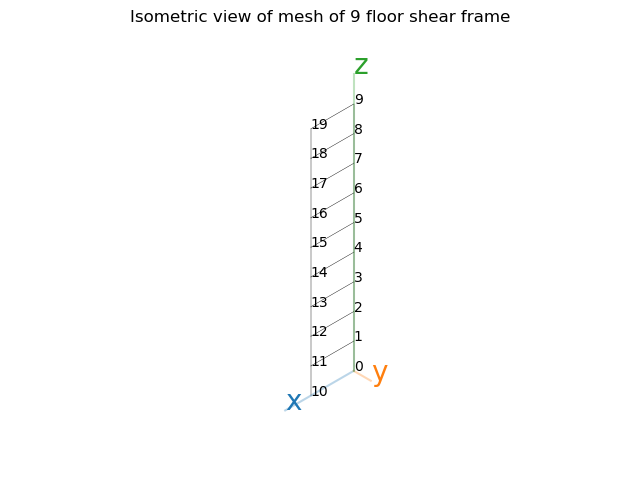

In [4]:
viso = strid.spatial.VisualizerIsometric(model)
viso.plot()
viso.figure.suptitle("Isometric view of mesh of 9 floor shear frame")

# Plot coordinate system
ex, ey, ez = np.eye(3)
csys = {"x": 8*ex, "y": 2*ey, "z": 10*3*ez}
for axis, unitvector in csys.items():
    x_2D, y_2D = strid.spatial.isometric_projection(unitvector).T
    l, = viso.axes.plot([0., x_2D], [0., y_2D], alpha=.3)
    viso.axes.text(x_2D, y_2D, axis, color=l.get_color(), fontsize=20)

Since our model is of a 2D shear frame in the XZ plane, we use the `VisualizerXZ` object in the continuation. 

We have already seen that we can plot the elements, nodes and node numbers with the `Visualizer.plot` method. This is useful in itself, especially when building a spatial model and mesh. We can also plot the elements, nodes and nodenumbers individuallly with the `plot_elements`, `plot_nodes` and `plot_nodenumbers` method individually.

<IPython.core.display.Javascript object>


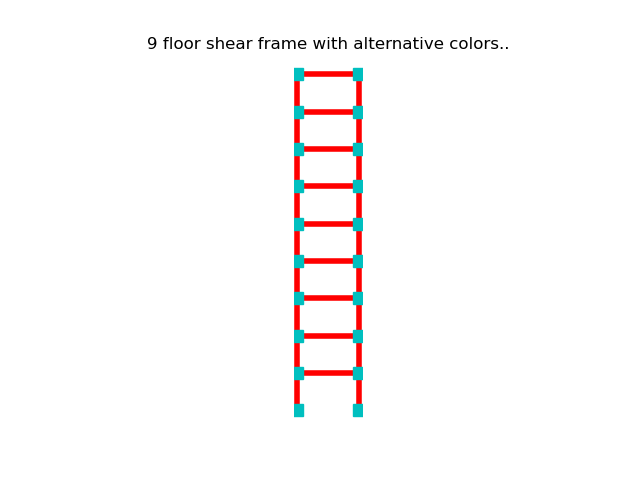

Text(0.5, 1.0, '9 floor shear frame with alternative colors..')

In [5]:
vxz = strid.spatial.VisualizerXZ(model)
vxz.plot_elements(color='r', lw=4)
vxz.plot_nodes(marker='s', markersize=9, color='c')
vxz.axes.set_title('9 floor shear frame with alternative colors..')

More importantly, we can plot the mode shape of the spatial model. Below we plot the second mode shape that we identified previously over the undeformed geometry of the shear frame.

<IPython.core.display.Javascript object>


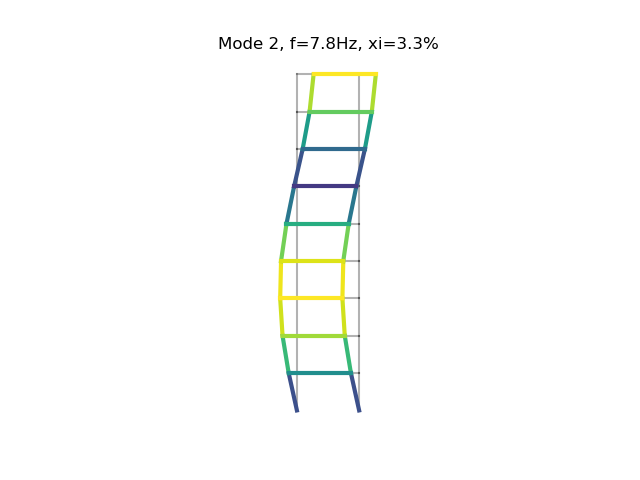

[Text(0.5, 1.0, 'Mode 2, f=7.8Hz, xi=3.3%')]

In [6]:
mode = modes[1] # second mode

vxz = strid.spatial.VisualizerXZ(model)
vxz.plot_elements(alpha=.3) #undeformed geometry
vxz.plot_elements(mode=mode, amplitude=3, colormap='viridis', lw=3) # deformed geometry/ mode shape
vxz.axes.set(title=f"Mode 2, f={mode.f:.1f}Hz, xi={mode.xi:.1%}")

A static plot of a mode shape is useful, but what is even better is an animation of the mode shape. The Visualizer objects provide the `animate` method to easily animate our mode shape:

<IPython.core.display.Javascript object>


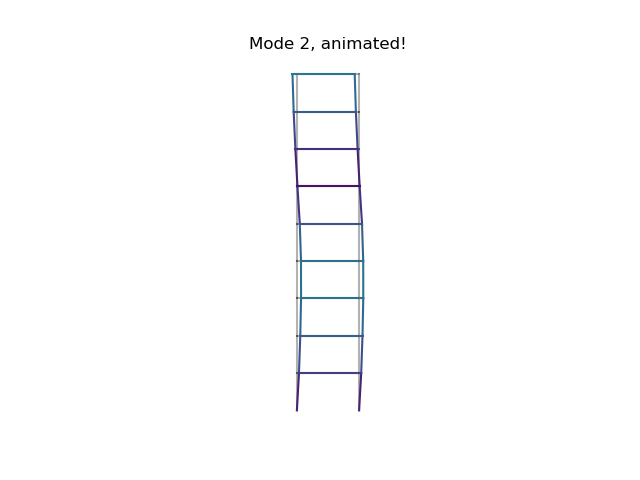

[Text(0.5, 1.0, 'Mode 2, animated!')]

In [7]:
vxz = strid.spatial.VisualizerXZ(model)
vxz.plot_elements(alpha=.3)
animation = vxz.animate(mode, amplitude=2)
vxz.axes.set(title="Mode 2, animated!")

Note that you can pause and resume the animation with `animation.pause()` and `animation.resume()`

You can also create video files of the animation:

In [8]:
animation.save("results/mode2.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.


(Below you see the gif of mode shape 2)

![mode2](mode2.gif)

Let us create animations of all mode shapes, create a html file and view them all together:

<IPython.core.display.Javascript object>


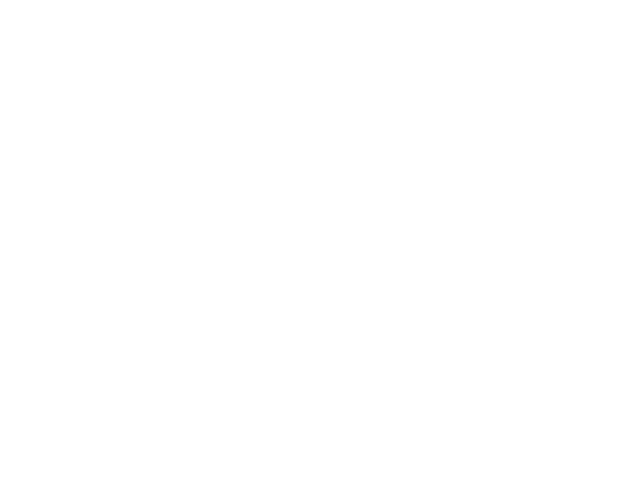

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


In [9]:
vxz = strid.spatial.VisualizerXZ(model)

with open("modes.html", 'w') as fout:
    for i, mode in enumerate(modes):
        vxz.plot_elements(alpha=.3)
        vxz.axes.set(title=f"Mode {i+1:02n}, f={mode.f:.1f}Hz, xi={mode.xi:.1%}")
        animation = vxz.animate(mode, amplitude=2, color='r')
        fname = f"results/mode{i:02n}.gif"
        animation.save(fname)
        fout.write(f'<img src="{fname}" alt="Mode{i:02n}"  width="500" />\n')
        del animation
        vxz.axes.clear()
        vxz.axes.axis('off')

plt.close()

See all our mode shapes in your browser here: [modes.html](modes.html)

In this example, we have used matplotlib to visualize the mesh of our shear frame. Matplotlib may be sufficient for many visualization tasks, especially for 2D structures, and perhaps also for 3D structures when an appropriate projection is used, in addition to the ones already implemented in strid, you can also implement your own by subclassing any of the `Visualizer` objects and redefining the `projection` method.

However, for general 3D structures, it may be necessary to look outside of `matplotlib`. Some suggestions  (at the time of writing this example) for 3D plotting in python are the packages `pyvista` and `mayavi`. 

Another option is to go outside of python.

[ParaView](https://www.paraview.org/) is an open-source, multi-platform data analysis and visualization application designed for visualizing and animating meshes. 

Below, we export the mesh and the mode shapes to a `.vtu` file with the `meshio` package. The mesh and modeshapes can then be imported into ParaView and further analyzed therein. See animation from ParaView of mode shape 3 below. 

In [12]:
import meshio

point_data ={}
for i, mode in enumerate(modes):
    # Rotate complex mode with mean phase to maximize real part
    u = (mode.v*np.exp(-1j*mode.mp)).real
    # Add displacement vectors U for nodes to point data dict
    point_data[f"Mode {i+1}"] = model.U(u)
    

mesh = meshio.Mesh(model.X0, model.topology, point_data=point_data)
mesh.write("results/shear-frame.vtu")

![mode3](results/mode3-paraview.gif)